In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss
1,1.611918,0.914003
2,0.849753,0.676412
3,0.648949,0.670127


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [9]:
path=Path('data/ml-100k/')

In [10]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
len(ratings)

100000

In [13]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [14]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [15]:
data.show_batch()

userId,title,target
601,"Ghost and the Darkness, The (1996)",3.0
605,"Preacher's Wife, The (1996)",4.0
542,Mighty Aphrodite (1995),4.0
437,Groundhog Day (1993),5.0
23,To Kill a Mockingbird (1962),5.0


In [16]:
y_range = [0,5.5]

In [17]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


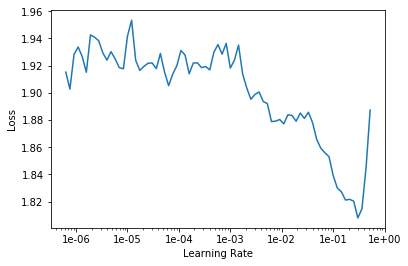

In [18]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [19]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.946623,0.946971
2,0.863614,0.880745
3,0.769410,0.839282
4,0.654852,0.816427
5,0.567388,0.816081


In [20]:
learn.save('dotprod')

## Interpretation

### Setup

In [22]:
learn.load('dotprod');

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [24]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

## Movie bias

In [25]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [27]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [28]:
item0 = lambda o:o[0]

In [29]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3743),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2946), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2861), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2834),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2745), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2630), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2601), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2374), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2327), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2319), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2319), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2278), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2173), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2136), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2090), 

In [30]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6258), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5869), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5817), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5493), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5463), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5175), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5148), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4895), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4868), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4866), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4814), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4758), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4740), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4715), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4664), 'Godfather, The (1972)', 4.283292978208232)]

## Movie weights

In [31]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [32]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [33]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [34]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2602), "McHale's Navy (1997)"),
 (tensor(1.2478), 'Jungle2Jungle (1997)'),
 (tensor(1.2304), 'Home Alone 3 (1997)'),
 (tensor(1.1954), 'Leave It to Beaver (1997)'),
 (tensor(1.1116), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1048), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0726), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(1.0616), 'Congo (1995)'),
 (tensor(1.0558), 'Bio-Dome (1996)'),
 (tensor(1.0475), 'Free Willy 3: The Rescue (1997)')]

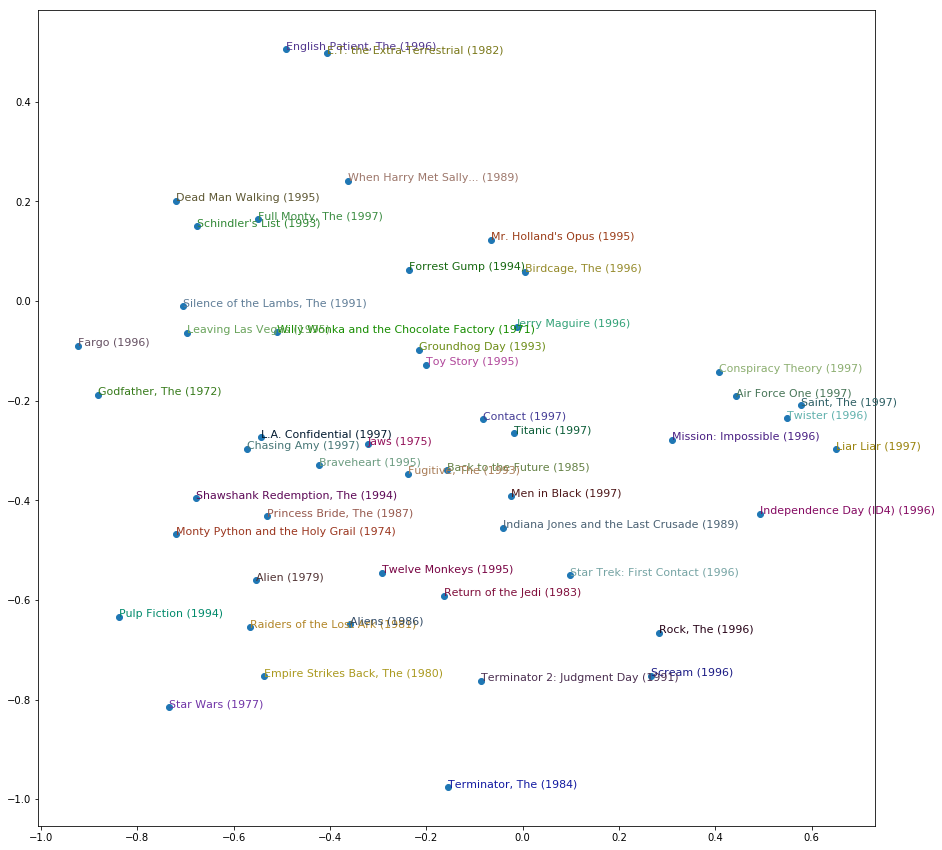

In [35]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()